
# EduGap: AI-Powered Digital Readiness Analyzer

**Date:** 2025-07-23

This notebook demonstrates the methodology behind **EduGap**, a machine learning–based tool designed to predict digital readiness using demographic features, and assess the effectiveness of interventions based on skill gain.

It supports a companion research paper and repository hosted on GitHub.


## Step 1: Import Required Libraries

In [88]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor


## Step 2: Load Dataset

In [89]:

# Load CSV file
data = pd.read_csv("digital_literacy_dataset.csv")
data.head()


,User_ID,Age,Gender,Education_Level,Employment_Status,Household_Income,Location_Type,Basic_Computer_Knowledge_Score,Internet_Usage_Score,Mobile_Literacy_Score,...,Modules_Completed,Average_Time_Per_Module,Quiz_Performance,Session_Count,Engagement_Level,Adaptability_Score,Feedback_Rating,Skill_Application,Employment_Impact,Overall_Literacy_Score
0,U0001,43,Male,Primary,Student,Medium,Semi-Rural,25,1,33,...,7,15.85,92,12,Low,77,4,51,Yes,58.2
1,U0002,60,Female,High School,Farmer,Low,Rural,22,14,35,...,9,22.24,88,24,Low,76,4,98,Yes,55.3
2,U0003,47,Female,Primary,Farmer,Low,Semi-Rural,14,31,14,...,13,12.15,67,17,Low,67,5,75,Yes,52.3
3,U0004,34,Female,Secondary,Farmer,Low,Rural,6,32,17,...,8,25.59,69,28,Medium,59,1,61,Yes,55.5
4,U0005,50,Male,High School,Other,Medium,Rural,14,41,19,...,8,16.65,76,10,Medium,90,4,82,No,59.3


## Step 3: Preprocess and Clean the Data
This includes handling missing values and standardizing category labels.

In [90]:
data.Education_Level.fillna("No School", inplace=True)

def clean(column):
    data[column] = data[column].astype(str).str.strip().str.title()


clean("Education_Level")
clean("Household_Income")
clean("Location_Type")
clean("Employment_Status")

bins = [0, 24, 40, 60, np.inf]
labels = ['Youth', 'Early Career', 'Midlife', 'Senior']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)


### Transform Categorical Data to Numerical Format

In [91]:
def map(column, mapping):
    data[column] = data[column].map(mapping)


education_map = {'No School': 0, 'Primary': 1, 'Secondary': 2, 'High School': 3}
income_map = {'Low': 0, 'Medium': 1, 'High': 2}
employment_map = {'Farmer': 0, 'Unemployed': 1, 'Student': 2, 'Other': 3, 'Self-Employed': 4}
age_map = {'Youth': 0, 'Senior': 1, 'Early Career': 2, 'Midlife': 3}

map("Education_Level", education_map)
map("Household_Income", income_map)
map("Employment_Status", employment_map)
map("Age_Group", age_map)


Using pre and post training skill scores to create columns to measure skill gains.

In [92]:
# Creating columns
data['Computer_Gain'] = data['Post_Training_Basic_Computer_Knowledge_Score'] - data['Basic_Computer_Knowledge_Score']
data['Internet_Gain'] = data['Post_Training_Internet_Usage_Score'] - data['Internet_Usage_Score']
data['Mobile_Gain'] = data['Post_Training_Mobile_Literacy_Score'] - data['Mobile_Literacy_Score']

## Step 4: Generate Target Labels from Raw Scores

In order to prepare the data for better analysis, they are turned into binary labels to measure gains as "Below Average" (class 0) and "Above Average" (class 1). Note: For simplicity purposes, the terms above and below average are used even though the median is used as the splitting point, not the mean. The median is used in order to improve equity and decrease potential skewness of the data and\or results. 

In [93]:

# Categorize and Labels (Access)
data['Computer_Skill_Label'] = data['Basic_Computer_Knowledge_Score'].apply(lambda x: 0 if x <= 25 else 1)
data['Internet_Usage_Label'] = data['Internet_Usage_Score'].apply(lambda x: 0 if x <= 25 else 1)
data['Mobile_Literacy_Label'] = data['Mobile_Literacy_Score'].apply(lambda x: 0 if x <= 26 else 1)

# Categorize and Labels (Skills)
data['Computer_Gain_Label'] = data['Basic_Computer_Knowledge_Score'].apply(lambda x: 0 if x <= 25 else 1)
data['Internet_Gain_Label'] = data['Internet_Usage_Score'].apply(lambda x: 0 if x <= 25 else 1)
data['Mobile_Gain_Label'] = data['Mobile_Literacy_Score'].apply(lambda x: 0 if x <= 26 else 1)



### Labeling for model performance improvements

Quantile based labeling was used in a seperate model in order to improve it's performance and abilities to identify underserved or high-risk groups (class 0) better. Median based labeling is better when using analysis and visualizations for equity purposes due to its interpretability and robustness against outliers. Quantile based labeling allows the model to learn patterns better and increase its ability to recognize class 0 (underserved) groups.

In [94]:
# Categorize and Labels (Access)
data['Computer_Skill_Label'] = data['Basic_Computer_Knowledge_Score'].apply(lambda x: 0 if x <= data['Basic_Computer_Knowledge_Score'].quantile(0.63) else 1)
data['Internet_Usage_Label'] = data['Internet_Usage_Score'].apply(lambda x: 0 if x <= data['Internet_Usage_Score'].quantile(0.56) else 1)
data['Mobile_Literacy_Label'] = data['Mobile_Literacy_Score'].apply(lambda x: 0 if x <= data['Mobile_Literacy_Score'].quantile(0.69) else 1)

# Categorize and Labels (Skills)
data['Computer_Gain_Label'] = data['Basic_Computer_Knowledge_Score'].apply(lambda x: 0 if x <= data['Computer_Gain'].quantile(.56) else 1)
data['Internet_Gain_Label'] = data['Internet_Usage_Score'].apply(lambda x: 0 if x <= data['Internet_Gain'].quantile(.55) else 1)
data['Mobile_Gain_Label'] = data['Mobile_Literacy_Score'].apply(lambda x: 0 if x <= data['Mobile_Gain'].quantile(.6) else 1)

### Labeling for identifying underserved groups.

## Step 5: Create X and Y Variables and Check for Multicollinearity using VIF

Multicollinearity, or the occurrence of two or more explanatory variables being very highly linearly related which can lead to misleading conclusions. Values above five are generally considered as having high multicollinearity present.

In [95]:

x = data[["Education_Level", "Household_Income", "Employment_Status", "Age_Group"]]
y = data[['Computer_Skill_Label', "Internet_Usage_Label", "Mobile_Literacy_Label"]]


features = data[["Education_Level", "Household_Income", "Employment_Status", "Age_Group"]]
x_df = pd.DataFrame(x, columns=features.columns)
vif_data = pd.DataFrame()
vif_data["Feature"] = x_df.columns
vif_data["VIF"] = [variance_inflation_factor(x_df.values, i) for i in range(x_df.shape[1])]

print(vif_data)

             Feature       VIF
0    Education_Level  2.471504
1   Household_Income  1.485290
2  Employment_Status  2.282504
3          Age_Group  2.878788


## Step 6: Train Random Forest Multi-Output Classifier

Various different models were tested and their accuracy score and classification metrics were tracked in order to find the most efficient model for the task at hand: MultiOutputClassifier. Different parameters and values were tested, as well, to train the model to perform its best. 

### Model Configuration
- 'n_estimators = 200' to increase the model's robustness
- 'max_depth = 15' to prevent overfitting by limiting how deep trees go
- 'max_features = 'sqrt'' to improve generalization by adding randomness
- 'min_samples_lead = 4' to prevent the model from creating tiny, noisy leaves (overfitting)
- 'min_samples_split = 5' to make sure splits are meanigful
- 'class_weight =  'balanced'' to ensure both classes are equally represented

In [96]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = MultiOutputClassifier(RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_leaf=4,
    min_samples_split=5,
    class_weight='balanced',
    max_features='sqrt',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
))
model.fit(X_train, y_train)

,estimator,RandomForestC...ndom_state=42)
,n_jobs,None
,n_estimators,200
,criterion,'gini'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0


## Step 7: Evaluate the Model’s Performance

In [97]:

ypred = model.predict(X_test)


# Convert predictions to DataFrame for easier inspection

ypred_df = pd.DataFrame(ypred, columns=y.columns)

# Loop through each target and print classification metrics
for label in y.columns:
    print(f"\n=== Classification Metrics for: {label} ===")
    print("\nClassification Report:")
    print(classification_report(y_test[label], ypred_df[label]))
    print("Accuracy: ", accuracy_score(y_test[label], ypred_df[label]))




=== Classification Metrics for: Computer_Skill_Label ===

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.60      0.62       119
           1       0.46      0.51      0.48        81

    accuracy                           0.56       200
   macro avg       0.55      0.55      0.55       200
weighted avg       0.57      0.56      0.56       200

Accuracy:  0.56

=== Classification Metrics for: Internet_Usage_Label ===

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.66      0.66       110
           1       0.58      0.58      0.58        90

    accuracy                           0.62       200
   macro avg       0.62      0.62      0.62       200
weighted avg       0.62      0.62      0.62       200

Accuracy:  0.625

=== Classification Metrics for: Mobile_Literacy_Label ===

Classification Report:
              precision    recall  f1-score   support

           

## Step 8: Feature Importance

Produces a bar graph that indicates how important each feature is.


 Feature importances for: Computer_Skill_Label
Education_Level           0.2624
Household_Income          0.1763
Employment_Status         0.3322
Age_Group                 0.2291

 Feature importances for: Internet_Usage_Label
Education_Level           0.2881
Household_Income          0.1663
Employment_Status         0.3142
Age_Group                 0.2314

 Feature importances for: Mobile_Literacy_Label
Education_Level           0.2702
Household_Income          0.1693
Employment_Status         0.3063
Age_Group                 0.2542


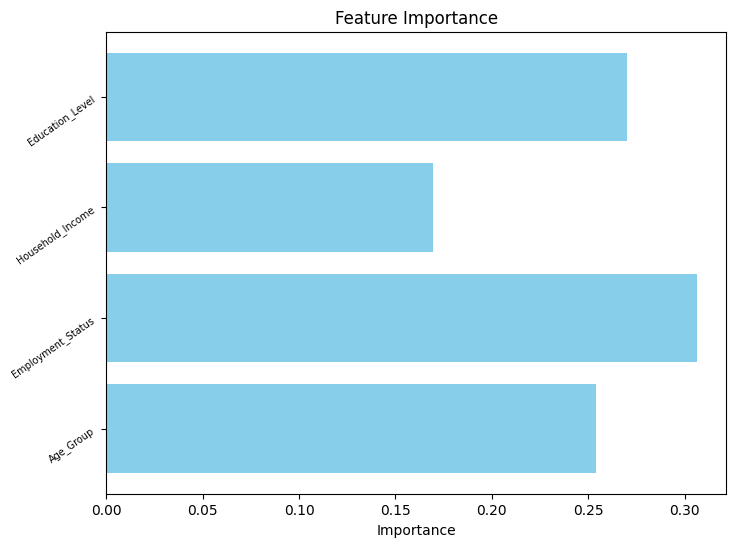

In [98]:
# Feature Importance
features = []
for i, label in enumerate(y.columns):
    print(f"\n Feature importances for: {label}")
    estimator = model.estimators_[i]

    importances = estimator.feature_importances_
    for feature, score in zip(x.columns, importances):
        print(f"{feature:<25} {score:.4f}")
        features.append(feature)

# Feature Importance
features = list(x)
plt.figure(figsize=(8, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.yticks(rotation=35, size = 7)
plt.gca().invert_yaxis()
plt.show()

## Step 9: Calculations and Visualizations (Graphs)

To identify underserved groups and how to improve future digital divide intervention efforts, functions to calculate amount below "average" (the median or middle value) ['averages_calculate'] and graph the top two graphs most below "average" ['bar_graph'] were created.

In [99]:
#Plotting and Calculating
#Based on data for comparison of ML's revelations
def averages_calculate(df, group_col, label_col, title_prefix=""):
    grouped = df.groupby(group_col)[label_col].value_counts(normalize=True).unstack().fillna(0)
    grouped.columns = ['Below Average', 'Above Average']
    print(grouped)

#To show ML revelations for underserved group
def bar_graph(df, group_cols, label_col, top_n, title_prefix):
    worst_groups = []
    proportions = []
    for group in group_cols:
        grouped = df.groupby(group)[label_col].value_counts(normalize=True).unstack().fillna(0)
        grouped.columns = ['Below Average', 'Above Average']
        top_worst = grouped['Below Average'].sort_values(ascending=False).head(top_n)
        for idx, val in top_worst.items():
            worst_groups.append(f"{group}: {idx}")
            proportions.append(val)
    plt.ylabel("Proportion Below Average")
    bars = plt.bar(worst_groups, proportions, color='firebrick')
    plt.title(f"{title_prefix}")
    plt.xticks(rotation=35)
    plt.tight_layout()
    plt.show()


Example of calling both functions


Computer Skill Inequity

              Below Average  Above Average
Income_Label                              
High               0.622951       0.377049
Low                0.647059       0.352941
Medium             0.667845       0.332155
                 Below Average  Above Average
Education_Label                              
High School           0.614754       0.385246
No School             0.693396       0.306604
Primary               0.664234       0.335766
Secondary             0.633333       0.366667
                  Below Average  Above Average
Employment_Label                              
Farmer                 0.670103       0.329897
Other                  0.634409       0.365591
Self-Employed          0.668342       0.331658
Student                0.636364       0.363636
Unemployed             0.640816       0.359184
              Below Average  Above Average
Age_Label                                 
Youth              0.623288       0.376712
Early Career       0.7089

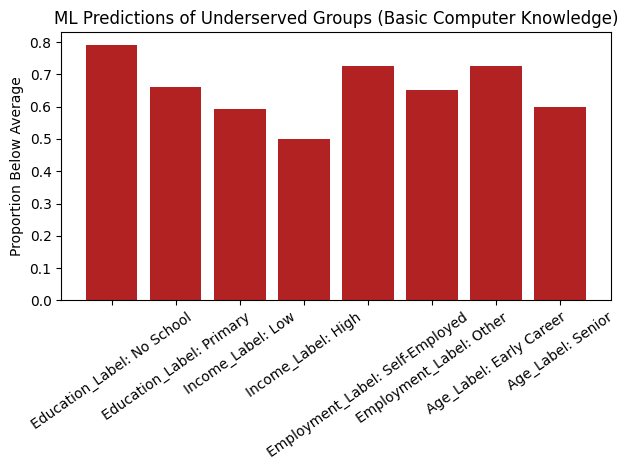

In [100]:
# Reverse maps (reapplied for labels)
education_reverse_map = {0: 'No School', 1: 'Primary', 2: 'Secondary', 3: 'High School'}
income_reverse_map = {0: 'Low', 1: 'Medium', 2: 'High'}
employment_reverse_map = {0: 'Farmer', 1: 'Unemployed', 2: 'Student', 3: 'Other', 4: 'Self-Employed'}
age_reverse_map = {0: 'Youth', 1: 'Senior', 2: 'Early Career', 3: 'Midlife'}
engagement_reverse_map = {0: 'Low', 1: 'Medium', 'High': 2}

# Apply readable labels
data['Education_Label'] = data['Education_Level'].map(education_reverse_map)
data['Income_Label'] = data['Household_Income'].map(income_reverse_map)
data['Employment_Label'] = data['Employment_Status'].map(employment_reverse_map)
data['Age_Label'] = data['Age_Group'].map(age_reverse_map)
data['Engagement_Label'] = data['Engagement_Level']

#Get Machine Learning predictions to use for bar graphs to portray models' revelations
xtest_reset = X_test.reset_index(drop=True)
labels_reset = data[['Education_Label', 'Income_Label', 'Employment_Label', 'Age_Label']].iloc[X_test.index].reset_index(drop=True)

xtest_with_labels = pd.concat([xtest_reset, labels_reset], axis=1)

group_data = xtest_with_labels[['Education_Label', 'Income_Label', 'Employment_Label', 'Age_Label']].reset_index(drop=True)

pred_cols = ['Computer_Skill_Pred', 'Internet_Usage_Pred', 'Mobile_Literacy_Pred']
pred_df = ypred_df.copy()
pred_df.columns = pred_cols

ml_data = group_data.copy()
ml_data[pred_cols] = pred_df[pred_cols]


# Calling Computer Skill Inequity
print("")
print("Computer Skill Inequity")
print("")
averages_calculate(data, 'Income_Label', 'Computer_Skill_Label', 'ML Predicted Skills')
averages_calculate(data, 'Education_Label', 'Computer_Skill_Label', 'Computer Skill Levels')
averages_calculate(data, 'Employment_Label', 'Computer_Skill_Label', 'Basic_Computer_Knowledge_Score')
averages_calculate(data, 'Age_Label', 'Computer_Skill_Label', 'Basic_Computer_Knowledge_Score')
print("")

# Graphs to see ML predictions
features_1 = ["Education_Label", "Income_Label", "Employment_Label", "Age_Label"]

bar_graph(ml_data, features_1, 'Computer_Skill_Pred', 2, 'ML Predictions of Underserved Groups (Basic Computer Knowledge)')





## Conclusion

This study used machine learning to portray its potential to identify and analyze nuanced patterns of digital inequity across socioeconomic and demographic groups. By classifying individuals below or above average in digital readiness and skill gain, the model successfully revealed that individuals with lower levels or no education, unemployment or informal employment, younger, and low and high income groups are most significantly underserved. Though, it tended to underestimate midlife and senior groups.

Though the predictions also accurately indicated that multiple of these same groups, like early career and secondary schooling, showed high potential for improvement by not underestimating their growth. This suggests that targeted interventions have the possibilities for producing meaningful impact if properly implemented. Though, the model was able to reveal groups like unemployed, youth, low income, and no schooling need to continue to be targeted when it comes to intervention efforts because they, having the potential to grow too, still struggle with lower literacy levels. The combination of model based prediction and group level analysis allowed a scalable method for identifying inequity. 

While limitations such as synthetic data and modest accuracy need to be acknowledged, this research lays important groundwork for future real-world applications. It demonstrates how machine learning can support data-driven policy decisions, continuous assessment, and targeted program development aimed at narrowing the digital divide. With further refinement and real-world validation, this project can become a powerful asset in the pursuit of digital equity.
